# Reconocimiento de emociones

En este archivo se presentarán diversas alternativas para el reconocimiento y análisis de emociones en Hilos de diferente largo.

Para comodidad del lector primero se analizará solo un tweet, luego de presentar el método de análisis se procederá a trabajar todo el dataset.

## Importación de liberias y apertura de archivos

In [26]:
import os
import random
import pandas as pd
import pymongo
from twython import Twython
import time

In [27]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import Span

output_notebook()

Loading BokehJS ...

In [28]:
from emotion_predictor import EmotionPredictor

In [29]:
#conexion mongo
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["twitter-memoria"]
coleccion_completa = mydb["nuevos_tweets"]
bd_hilos = mydb["nuevos_hilos"]

#obtener llaves Twitter
llaves_bd = mydb["llaves"]
llaves = llaves_bd.find_one()

APP_KEY = llaves["API_KEY"]
ACCESS_TOKEN  = llaves["ACCESS_TOKEN_T"]
twitter       = Twython(APP_KEY, access_token=ACCESS_TOKEN)


## Threads como diccionario y como arreglo de string

Se tienen dos formatos para trabajar los datos. El primero es como un diccionario de threads, el cual la clave es el numero de thread y el valor es un arreglo de strings con todos los tweets del thread. La otra es un arreglo de strings, los cuales son todos los tweets unidos en orden separados con un \n

In [30]:
tweets = coleccion_completa.find({})
hilos = bd_hilos.find({})

threads1 = {}
kthreads1 = {}

all_hilos = {}
for hilo in hilos:
    all_tweets = []
    n_hilo = hilo["hilo"]
    tweets = coleccion_completa.find({"hilo":n_hilo})
    for tweet in tweets:
        tweet_aux = {}
        tweet_aux["hilo"] = n_hilo
        tweet_aux["posicion"] = tweet["pos_hilo"]
        tweet_aux["texto"] = tweet["text"]
        all_tweets.append(tweet_aux)    
    all_tweets_sorted = sorted(all_tweets, key = lambda i: i['posicion'])
    nombre = "hilo "+str(n_hilo)
    all_hilos[nombre] = all_tweets_sorted

string = '\n'
for hilo in all_hilos:
    tweets = all_hilos[hilo]
    lista_tweets = []
    for tweet in tweets:
        lista_tweets.append(tweet["texto"])
    threads1[hilo] = lista_tweets
    kthreads1[hilo] = string.join(lista_tweets)
    
Tthreads1 = list(kthreads1.values())

In [31]:
threads1["hilo 1"]

['NEW: Former president Jimmy Carter says a full investigation “would show that Trump didn’t actually win the election in 2016….He was put into office because the Russians interfered.” Does that mean he’s an illegitimate president? “Based on what I said, which I can’t retract.” https://t.co/Y3UFUBIIDy',
 'At @CarterCenter conference on human rights moderated by historian Jon Meacham, former president Jimmy Carter says “every day we send a terrible signal” with border policy, “a disgrace to the United States, and I hope it will soon be ended. Maybe not until the 2020 election.”',
 'Former Vice President Walter Mondale on President Trump: “He’s got something deep in him that is detestable.” Cites “his rhetoric, his harshness, his divisiveness,” then adds: “Doctors tell me they think they recognize symptoms of psychological problems.” At @CarterCenter panel']

In [32]:
kthreads1

{'hilo 0': "In light of today's news from the 4th Cir. a reminder that those opposed to the census citizenship question have concocted a conspiracy theory to try and push back an anticipated loss at the Supreme Court later this week. \n\nSee thread -&gt; https://t.co/k5Cb7El9wU\nThe details are in that thread, but the bottom line is that there is no evidence that the dead guy's 2015 unpublished study had anything to do with Sec. Ross' census decision, but the left and the media have their story and they're sticking to it.\nWhy aren't more right-side journos and commentators picking it up? \n\nI don't know, but I have a theory: as with the Muslim Ban that wasn't really a Muslim Ban, the underlying accusation here is of racism, which has historically been a very successful method of shutting people up.",
 'hilo 1': 'NEW: Former president Jimmy Carter says a full investigation “would show that Trump didn’t actually win the election in 2016….He was put into office because the Russians inte

In [33]:
Tthreads1

["In light of today's news from the 4th Cir. a reminder that those opposed to the census citizenship question have concocted a conspiracy theory to try and push back an anticipated loss at the Supreme Court later this week. \n\nSee thread -&gt; https://t.co/k5Cb7El9wU\nThe details are in that thread, but the bottom line is that there is no evidence that the dead guy's 2015 unpublished study had anything to do with Sec. Ross' census decision, but the left and the media have their story and they're sticking to it.\nWhy aren't more right-side journos and commentators picking it up? \n\nI don't know, but I have a theory: as with the Muslim Ban that wasn't really a Muslim Ban, the underlying accusation here is of racism, which has historically been a very successful method of shutting people up.",
 'NEW: Former president Jimmy Carter says a full investigation “would show that Trump didn’t actually win the election in 2016….He was put into office because the Russians interfered.” Does that m

In [35]:
df_unidos1 = pd.DataFrame.from_dict(kthreads1, orient='index', columns=['Tweet'])

df_unidos1.index.name = "Hilo"
df_unidos1.reset_index(inplace=True)

df_unidos1.head()

Hilo                                              Tweet
0  hilo 0  In light of today's news from the 4th Cir. a r...
1  hilo 1  NEW: Former president Jimmy Carter says a full...
2  hilo 2  Everything we think of as futuristic is really...
3  hilo 3  Hatch dismisses allegations of Trump crimes ov...
4  hilo 4  What a weird coincidence that a group of accou...

## Detección de emociones.

Se importa el modelo a utilizar para la detección de emociones. Se trabajará con las emociones definidas por Ekman.

Se extraerán dos emociones por hilo, esto para posibles futuros análisis.

Existen dos alternativas para el output las emociones. La primera es a través de la predicción directa de la emoción, la cual entrega una tabla con la emoción principal de cada documento estudiado. La segunda es a través de una matriz de probabilidades, en la cual las columnas son las emociones y las filas los documentos a analizar. Cada valor de la matríz es la probabilidad de que el documento sea asociado a esa emoción.

In [36]:
ekman = EmotionPredictor(classification='ekman', setting='mc')

In [47]:
tweets = threads1["hilo 283"]
matriz = ekman.predict_probabilities(tweets)
tabla = ekman.predict_classes(tweets)

In [48]:
matriz

Tweet     Anger   Disgust  \
0   President Trump just scored a MASSIVE VICTORY ...  0.003390  0.006598   
1   Folded  like a wet blanket.  \n\nhttps://t.co/...  0.003578  0.002319   
2   And the do-over on the citizenship question in...  0.014561  0.001813   
3   House version of the bill which Pelosi and the...  0.003735  0.004701   
4   But I wake up and my mentions are full of peop...  0.046813  0.012257   
5   People who don't know how anything works are t...  0.004864  0.006576   
6   Trump used the USA's economic leverage quite r...  0.007432  0.000237   
7   Now that the funding is in hand to deal with t...  0.074415  0.003184   
8   Once Trump is reelected in 2020, we'll get the...  0.010908  0.002240   
9   But Trump's got to do this one step at a time,...  0.325977  0.022700   
10  Mexico closing it's own border &amp; sending t...  0.019930  0.031994   
11  Trump just getting Pelosi to very publicly CAV...  0.008716  0.010859   
12  Doom criers out there can spin any minor setba...  0.010519  0.055365   
13  And they do this just to get YOUR ATTENTION, y...  0.137699  0.073584   
14  LOL look how Politico described what just happ...  0.033795  0.051095   
15  Pound sand, you loser. \n\nYou're gone in the ...  0.013925  0.009487   
16  Exactly. It's sent back for 'clarification', w...  0.000212  0.000003   
17  Here's the difference between AOC and Pelosi: ...  0.012487  0.000148   
18  The far Left 'moderate' wing of the Party led ...  0.017511  0.002182   
19  AOC wants Sherman's march through Georgia, bur...  0.024456  0.019968   

        Fear       Joy   Sadness  Surprise  
0   0.025919  0.940366  0.004703  0.019023  
1   0.024027  0.376932  0.003468  0.589676  
2   0.027677  0.845014  0.023854  0.087081  
3   0.010376  0.895232  0.001698  0.084257  
4   0.476929  0.290694  0.016772  0.156535  
5   0.012071  0.468284  0.039252  0.468952  
6   0.002607  0.989158  0.000109  0.000456  
7   0.075167  0.746493  0.010804  0.089937  
8   0.039809  0.502761  0.011416  0.432866  
9   0.117686  0.521900  0.004743  0.006994  
10  0.564475  0.092688  0.018088  0.272825  
11  0.020641  0.918951  0.038725  0.002108  
12  0.444587  0.040410  0.363761  0.085358  
13  0.646251  0.053545  0.041099  0.047824  
14  0.237120  0.519245  0.107831  0.050913  
15  0.014207  0.064215  0.791417  0.106749  
16  0.020360  0.979244  0.000104  0.000077  
17  0.972557  0.011828  0.001026  0.001954  
18  0.257739  0.708939  0.001312  0.012316  
19  0.496054  0.233021  0.026051  0.200450

In [49]:
matriz.describe()

Anger    Disgust       Fear        Joy    Sadness   Surprise
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000
mean    0.038746   0.015866   0.224313   0.509946   0.075312   0.135818
std     0.074817   0.021138   0.280419   0.351900   0.186907   0.173524
min     0.000212   0.000003   0.002607   0.011828   0.000104   0.000077
25%     0.006790   0.002225   0.020571   0.197938   0.003026   0.010986
50%     0.013206   0.006587   0.057488   0.511003   0.014094   0.084807
75%     0.026791   0.020651   0.452673   0.857569   0.038857   0.167513
max     0.325977   0.073584   0.972557   0.989158   0.791417   0.589676

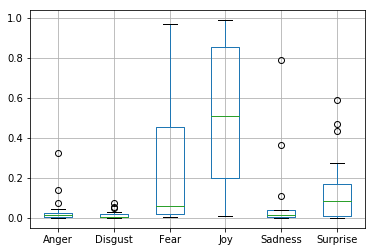

In [50]:
matriz.boxplot(column = ["Anger", "Disgust", "Fear", "Joy", "Sadness", "Surprise"])

In [51]:

grafico = figure(plot_width=700, 
           plot_height=350, 
           title='Probabilidad de cada emoción por tweet', 
           background_fill_color="#f2f3f7", 
           y_axis_label='probabilidad', 
           x_axis_label='Tweets along the thread')

grafico.line(list(range(1,21)), matriz['Anger'].values,line_color='#cd2626', legend='Enojo')
grafico.line(list(range(1,21)), matriz['Disgust'].values, line_color='#64bd40', legend='Disgusto')
grafico.line(list(range(1,21)), matriz['Fear'].values, line_color='#cbbeb5', legend='Miedo')
grafico.line(list(range(1,21)), matriz['Joy'].values, line_color='#ffe700', legend='Alegria')
grafico.line(list(range(1,21)), matriz['Sadness'].values, line_color='#7cb890', legend='Pena')
grafico.line(list(range(1,21)), matriz['Surprise'].values, line_color='#ff00db', legend='Sorpresa')

show(grafico)

In [52]:
tabla

Tweet   Emotion
0   President Trump just scored a MASSIVE VICTORY ...       Joy
1   Folded  like a wet blanket.  \n\nhttps://t.co/...  Surprise
2   And the do-over on the citizenship question in...       Joy
3   House version of the bill which Pelosi and the...       Joy
4   But I wake up and my mentions are full of peop...      Fear
5   People who don't know how anything works are t...  Surprise
6   Trump used the USA's economic leverage quite r...       Joy
7   Now that the funding is in hand to deal with t...       Joy
8   Once Trump is reelected in 2020, we'll get the...       Joy
9   But Trump's got to do this one step at a time,...       Joy
10  Mexico closing it's own border &amp; sending t...      Fear
11  Trump just getting Pelosi to very publicly CAV...       Joy
12  Doom criers out there can spin any minor setba...      Fear
13  And they do this just to get YOUR ATTENTION, y...      Fear
14  LOL look how Politico described what just happ...       Joy
15  Pound sand, you loser. \n\nYou're gone in the ...   Sadness
16  Exactly. It's sent back for 'clarification', w...       Joy
17  Here's the difference between AOC and Pelosi: ...      Fear
18  The far Left 'moderate' wing of the Party led ...       Joy
19  AOC wants Sherman's march through Georgia, bur...      Fear

In [53]:
tabla.describe()

Tweet Emotion
count                                                  20      20
unique                                                 20       4
top     But Trump's got to do this one step at a time,...     Joy
freq                                                    1      11

## Análisis de emociones según la matriz de probabilidades.

Se poseen varias alternativas para obtener la emoción del thread a través de la matriz, los cuales serán descritos a continuación:

In [54]:
matriz_valores = matriz.drop(columns ="Tweet")
matriz_valores

Anger   Disgust      Fear       Joy   Sadness  Surprise
0   0.003390  0.006598  0.025919  0.940366  0.004703  0.019023
1   0.003578  0.002319  0.024027  0.376932  0.003468  0.589676
2   0.014561  0.001813  0.027677  0.845014  0.023854  0.087081
3   0.003735  0.004701  0.010376  0.895232  0.001698  0.084257
4   0.046813  0.012257  0.476929  0.290694  0.016772  0.156535
5   0.004864  0.006576  0.012071  0.468284  0.039252  0.468952
6   0.007432  0.000237  0.002607  0.989158  0.000109  0.000456
7   0.074415  0.003184  0.075167  0.746493  0.010804  0.089937
8   0.010908  0.002240  0.039809  0.502761  0.011416  0.432866
9   0.325977  0.022700  0.117686  0.521900  0.004743  0.006994
10  0.019930  0.031994  0.564475  0.092688  0.018088  0.272825
11  0.008716  0.010859  0.020641  0.918951  0.038725  0.002108
12  0.010519  0.055365  0.444587  0.040410  0.363761  0.085358
13  0.137699  0.073584  0.646251  0.053545  0.041099  0.047824
14  0.033795  0.051095  0.237120  0.519245  0.107831  0.050913
15  0.013925  0.009487  0.014207  0.064215  0.791417  0.106749
16  0.000212  0.000003  0.020360  0.979244  0.000104  0.000077
17  0.012487  0.000148  0.972557  0.011828  0.001026  0.001954
18  0.017511  0.002182  0.257739  0.708939  0.001312  0.012316
19  0.024456  0.019968  0.496054  0.233021  0.026051  0.200450

### Emoción media

Se definió como emoción media a la columna que posea el promedio más alto. 

In [55]:
matriz_media = matriz_valores.mean().to_frame().transpose()
matriz_media

Anger   Disgust      Fear       Joy   Sadness  Surprise
0  0.038746  0.015866  0.224313  0.509946  0.075312  0.135818

In [56]:
matriz_media.sort_values(by = 0, axis = 1, ascending=False)

Joy      Fear  Surprise   Sadness     Anger   Disgust
0  0.509946  0.224313  0.135818  0.075312  0.038746  0.015866

In [57]:
matriz_emociones_media_max = list(matriz_media.sort_values(by = 0, axis = 1, ascending=False).iloc[:,0:2])
matriz_emociones_media_max

['Joy', 'Fear']

### Emoción más intensa

Se definió como emoción más intensa a la columna que posea el valor máximo más alto de todos.

In [58]:
matriz_emocion = matriz_valores.max().to_frame().transpose().sort_values(by = 0, axis = 1, ascending=False)
matriz_emocion

Joy      Fear   Sadness  Surprise     Anger   Disgust
0  0.989158  0.972557  0.791417  0.589676  0.325977  0.073584

In [59]:
matriz_emociones_max = list(matriz_emocion.sort_values(by = 0, axis = 1, ascending=False).iloc[:,0:2])
matriz_emociones_max

['Joy', 'Fear']

## Análisis de emociones según la tabla de emociones.

Para analizar las emociones según la tabla es posible considerar la frecuencia en la que aparecen las emociones.

### Emoción Moda

Se definió como emoción moda como la emoción que presenta la mayor frecuencia de aparición

In [60]:
tabla.Emotion.value_counts().to_frame().transpose()

Joy  Fear  Surprise  Sadness
Emotion   11     6         2        1

In [61]:
tabla_emociones_moda = list(tabla.Emotion.value_counts().to_frame().transpose().iloc[:,0:2])
tabla_emociones_moda

['Joy', 'Fear']

# Estudio de threads como un solo documento

Para estudiar los threads como un sólo documento, se unieron los tweets y luego se ingresó el dataset completo como una colección de documentos. cada fila es un thread y cada columna es la probabilidad de una emoción específica. En este caso solo se posee una forma de analizar las emociones.

### Emoción Hilo

Al existir sólo un arreglo de probabilidades para cada thread, la emoción con mayor probabilidad y la emoción en la tabla es la misma, por lo que de este caso sólo se pueden obtener las primeras 2 emociones más probables para cada thread.

In [62]:
Ttweets = Tthreads1
Tmatriz = ekman.predict_probabilities(Ttweets).drop(columns = "Tweet")

for index, row in Tmatriz.iterrows():
    Tmatriz_emocion = row.to_frame().transpose().sort_values(by = index, axis = 1, ascending=False)
    Tmatriz_emocion_max = list(Tmatriz_emocion.iloc[:,0:2])
    print(Tmatriz_emocion_max)


['Fear', 'Joy']
['Anger', 'Surprise']
['Sadness', 'Surprise']
['Joy', 'Surprise']
['Joy', 'Fear']
['Fear', 'Joy']
['Sadness', 'Joy']
['Joy', 'Surprise']
['Surprise', 'Sadness']
['Joy', 'Fear']
['Fear', 'Sadness']
['Fear', 'Surprise']
['Joy', 'Fear']
['Joy', 'Surprise']
['Surprise', 'Fear']
['Joy', 'Fear']
['Fear', 'Disgust']
['Joy', 'Surprise']
['Joy', 'Fear']
['Anger', 'Joy']
['Fear', 'Joy']
['Joy', 'Anger']
['Joy', 'Fear']
['Fear', 'Joy']
['Joy', 'Fear']
['Fear', 'Joy']
['Joy', 'Anger']
['Fear', 'Joy']
['Joy', 'Fear']
['Fear', 'Joy']
['Joy', 'Fear']
['Surprise', 'Sadness']
['Joy', 'Fear']
['Fear', 'Surprise']
['Joy', 'Fear']
['Fear', 'Joy']
['Fear', 'Joy']
['Sadness', 'Joy']
['Joy', 'Anger']
['Joy', 'Fear']
['Joy', 'Fear']
['Surprise', 'Joy']
['Fear', 'Joy']
['Joy', 'Fear']
['Surprise', 'Joy']
['Fear', 'Joy']
['Joy', 'Surprise']
['Joy', 'Fear']
['Joy', 'Fear']
['Anger', 'Sadness']
['Joy', 'Anger']
['Joy', 'Fear']
['Fear', 'Joy']
['Joy', 'Fear']
['Anger', 'Sadness']
['Joy', 'Anger']
[

# Estudio del dataset completo por tweets separados.

Luego de presentar todos los métodos definidos para obtención la emoción para cada thread, se procede a calcularlos.

## CSV five_ten

In [63]:
threads_estudio = threads1

tweets_analisis = []

emocion_media = []
emocion_presente = []
emocion_moda = []

etiquetas = ["Thread", "1ra Emocion", "2da Emocion"]


for hilo in threads_estudio:
    print(hilo)
    #Conseguir Emociones
    tweets_analisis = threads_estudio[hilo]
    matriz_hilo_analizado = ekman.predict_probabilities(tweets_analisis).drop(columns ="Tweet")
    tabla_hilo_analizado = ekman.predict_classes(tweets_analisis)
    
    #Emocion media
    matriz_media_analisis = matriz_hilo_analizado.mean().to_frame().transpose()
    matriz_emociones_media_max_analisis = list(matriz_media_analisis.sort_values(by = 0, axis = 1, ascending=False).iloc[:,0:2])
    matriz_emociones_media_max_analisis.insert(0, hilo)
    print(matriz_emociones_media_max_analisis)
    
    #Emocion mas intensa
    matriz_emocion_analisis = matriz_hilo_analizado.max().to_frame().transpose().sort_values(by = 0, axis = 1, ascending=False)
    matriz_emociones_max_analisis = list(matriz_emocion_analisis.sort_values(by = 0, axis = 1, ascending=False).iloc[:,0:2])
    matriz_emociones_max_analisis.insert(0, hilo)
    print(matriz_emociones_max_analisis)
    
    #Emocion moda
    tabla_emociones_moda_analisis = list(tabla_hilo_analizado.Emotion.value_counts().to_frame().transpose().iloc[:,0:2])
    tabla_emociones_moda_analisis.insert(0, hilo)
    print(tabla_emociones_moda_analisis)
    
    
    #Agregar a lista de listas
    
    emocion_media.append(matriz_emociones_media_max_analisis)
    emocion_presente.append(matriz_emociones_max_analisis)
    emocion_moda.append(tabla_emociones_moda_analisis)

# Creacion de dataframes    
dataframe_emocion_media = pd.DataFrame.from_records(emocion_media, columns = etiquetas)
dataframe_emocion_presente = pd.DataFrame.from_records(emocion_presente, columns = etiquetas)
dataframe_emocion_moda = pd.DataFrame.from_records(emocion_moda, columns = etiquetas)

# Guardado de dataframes

dataframe_emocion_media_1 = dataframe_emocion_media
dataframe_emocion_presente_1 = dataframe_emocion_presente
dataframe_emocion_moda_1 = dataframe_emocion_moda

hilo 0
['hilo 0', 'Fear', 'Joy']
['hilo 0', 'Fear', 'Joy']
['hilo 0', 'Fear', 'Joy']
hilo 1
['hilo 1', 'Joy', 'Anger']
['hilo 1', 'Joy', 'Anger']
['hilo 1', 'Joy', 'Anger']
hilo 2
['hilo 2', 'Joy', 'Fear']
['hilo 2', 'Joy', 'Fear']
['hilo 2', 'Sadness', 'Joy']
hilo 3
['hilo 3', 'Joy', 'Surprise']
['hilo 3', 'Surprise', 'Joy']
['hilo 3', 'Joy', 'Surprise']
hilo 4
['hilo 4', 'Joy', 'Fear']
['hilo 4', 'Joy', 'Fear']
['hilo 4', 'Joy', 'Fear']
hilo 5
['hilo 5', 'Fear', 'Anger']
['hilo 5', 'Anger', 'Fear']
['hilo 5', 'Fear', 'Anger']
hilo 6
['hilo 6', 'Joy', 'Disgust']
['hilo 6', 'Disgust', 'Fear']
['hilo 6', 'Fear', 'Joy']
hilo 7
['hilo 7', 'Joy', 'Fear']
['hilo 7', 'Joy', 'Surprise']
['hilo 7', 'Joy']
hilo 8
['hilo 8', 'Joy', 'Fear']
['hilo 8', 'Joy', 'Fear']
['hilo 8', 'Surprise', 'Joy']
hilo 9
['hilo 9', 'Joy', 'Fear']
['hilo 9', 'Joy', 'Fear']
['hilo 9', 'Joy', 'Surprise']
hilo 10
['hilo 10', 'Fear', 'Disgust']
['hilo 10', 'Fear', 'Disgust']
['hilo 10', 'Fear', 'Disgust']
hilo 11
['hilo

['hilo 89', 'Joy', 'Sadness']
['hilo 89', 'Joy', 'Sadness']
['hilo 89', 'Sadness', 'Joy']
hilo 90
['hilo 90', 'Joy', 'Anger']
['hilo 90', 'Joy', 'Anger']
['hilo 90', 'Joy', 'Anger']
hilo 91
['hilo 91', 'Joy', 'Fear']
['hilo 91', 'Joy', 'Fear']
['hilo 91', 'Joy', 'Fear']
hilo 92
['hilo 92', 'Joy', 'Surprise']
['hilo 92', 'Surprise', 'Joy']
['hilo 92', 'Joy', 'Fear']
hilo 93
['hilo 93', 'Joy', 'Fear']
['hilo 93', 'Joy', 'Anger']
['hilo 93', 'Joy', 'Anger']
hilo 94
['hilo 94', 'Joy', 'Fear']
['hilo 94', 'Fear', 'Joy']
['hilo 94', 'Joy', 'Anger']
hilo 95
['hilo 95', 'Fear', 'Joy']
['hilo 95', 'Fear', 'Joy']
['hilo 95', 'Joy', 'Fear']
hilo 96
['hilo 96', 'Joy', 'Fear']
['hilo 96', 'Joy', 'Fear']
['hilo 96', 'Joy', 'Fear']
hilo 97
['hilo 97', 'Joy', 'Surprise']
['hilo 97', 'Joy', 'Surprise']
['hilo 97', 'Joy', 'Fear']
hilo 98
['hilo 98', 'Joy', 'Fear']
['hilo 98', 'Fear', 'Joy']
['hilo 98', 'Joy', 'Fear']
hilo 99
['hilo 99', 'Joy', 'Fear']
['hilo 99', 'Joy', 'Fear']
['hilo 99', 'Joy', 'Fear'

['hilo 175', 'Fear', 'Joy']
['hilo 175', 'Fear', 'Anger']
['hilo 175', 'Joy', 'Fear']
hilo 176
['hilo 176', 'Joy', 'Fear']
['hilo 176', 'Joy', 'Fear']
['hilo 176', 'Joy', 'Fear']
hilo 177
['hilo 177', 'Joy', 'Fear']
['hilo 177', 'Joy', 'Fear']
['hilo 177', 'Joy', 'Fear']
hilo 178
['hilo 178', 'Joy', 'Surprise']
['hilo 178', 'Joy', 'Surprise']
['hilo 178', 'Joy', 'Surprise']
hilo 179
['hilo 179', 'Joy', 'Surprise']
['hilo 179', 'Joy', 'Disgust']
['hilo 179', 'Joy', 'Fear']
hilo 180
['hilo 180', 'Joy', 'Surprise']
['hilo 180', 'Joy', 'Anger']
['hilo 180', 'Joy', 'Surprise']
hilo 181
['hilo 181', 'Joy', 'Fear']
['hilo 181', 'Joy', 'Fear']
['hilo 181', 'Joy', 'Fear']
hilo 182
['hilo 182', 'Joy', 'Fear']
['hilo 182', 'Joy', 'Fear']
['hilo 182', 'Joy', 'Fear']
hilo 183
['hilo 183', 'Surprise', 'Joy']
['hilo 183', 'Surprise', 'Joy']
['hilo 183', 'Surprise', 'Joy']
hilo 184
['hilo 184', 'Joy', 'Fear']
['hilo 184', 'Joy', 'Fear']
['hilo 184', 'Joy', 'Fear']
hilo 185
['hilo 185', 'Joy', 'Fear']


['hilo 261', 'Fear', 'Joy']
['hilo 261', 'Fear', 'Joy']
['hilo 261', 'Fear', 'Joy']
hilo 262
['hilo 262', 'Fear', 'Joy']
['hilo 262', 'Fear', 'Joy']
['hilo 262', 'Fear', 'Joy']
hilo 263
['hilo 263', 'Fear', 'Joy']
['hilo 263', 'Joy', 'Fear']
['hilo 263', 'Fear', 'Joy']
hilo 264
['hilo 264', 'Joy', 'Surprise']
['hilo 264', 'Joy', 'Disgust']
['hilo 264', 'Joy', 'Surprise']
hilo 265
['hilo 265', 'Joy', 'Fear']
['hilo 265', 'Joy', 'Fear']
['hilo 265', 'Joy', 'Fear']
hilo 266
['hilo 266', 'Fear', 'Joy']
['hilo 266', 'Fear', 'Sadness']
['hilo 266', 'Fear', 'Joy']
hilo 267
['hilo 267', 'Joy', 'Surprise']
['hilo 267', 'Joy', 'Surprise']
['hilo 267', 'Joy', 'Surprise']
hilo 268
['hilo 268', 'Joy', 'Fear']
['hilo 268', 'Joy', 'Fear']
['hilo 268', 'Joy', 'Fear']
hilo 269
['hilo 269', 'Joy', 'Fear']
['hilo 269', 'Joy', 'Fear']
['hilo 269', 'Joy', 'Fear']
hilo 270
['hilo 270', 'Joy', 'Fear']
['hilo 270', 'Joy', 'Fear']
['hilo 270', 'Joy', 'Fear']
hilo 271
['hilo 271', 'Joy', 'Fear']
['hilo 271', 'J

['hilo 348', 'Fear', 'Joy']
['hilo 348', 'Surprise', 'Fear']
['hilo 348', 'Joy', 'Fear']
hilo 349
['hilo 349', 'Joy', 'Fear']
['hilo 349', 'Joy', 'Sadness']
['hilo 349', 'Joy', 'Fear']
hilo 350
['hilo 350', 'Joy', 'Surprise']
['hilo 350', 'Joy', 'Fear']
['hilo 350', 'Joy', 'Surprise']
hilo 351
['hilo 351', 'Joy', 'Fear']
['hilo 351', 'Sadness', 'Joy']
['hilo 351', 'Joy', 'Fear']
hilo 352
['hilo 352', 'Joy', 'Surprise']
['hilo 352', 'Joy', 'Surprise']
['hilo 352', 'Surprise', 'Joy']
hilo 353
['hilo 353', 'Joy', 'Fear']
['hilo 353', 'Joy', 'Fear']
['hilo 353', 'Joy', 'Fear']
hilo 354
['hilo 354', 'Joy', 'Fear']
['hilo 354', 'Joy', 'Fear']
['hilo 354', 'Joy', 'Fear']
hilo 355
['hilo 355', 'Joy', 'Fear']
['hilo 355', 'Joy', 'Anger']
['hilo 355', 'Joy', 'Fear']
hilo 356
['hilo 356', 'Joy', 'Fear']
['hilo 356', 'Joy', 'Fear']
['hilo 356', 'Joy', 'Fear']
hilo 357
['hilo 357', 'Joy', 'Fear']
['hilo 357', 'Joy', 'Surprise']
['hilo 357', 'Joy', 'Surprise']
hilo 358
['hilo 358', 'Joy', 'Fear']
['

# Estudio del dataset completo por threads unidos.

## CSV five_ten

In [64]:
Ttweets = Tthreads1
Tmatriz = ekman.predict_probabilities(Ttweets)
Tdf_unidos = df_unidos1

Tmatriz_emocion = []
Tmatriz_emocion_max = []

Temocion_max = []
dataframe_Temocion_max = []

unidos = []
u2 = []

unidos = Tdf_unidos.join(Tmatriz.set_index('Tweet'), on='Tweet')
u2 = unidos.set_index("Hilo").drop(columns = ["Tweet"])

#Sacar dos emociones maximas
for index, row in u2.iterrows():
    Tmatriz_emocion = row.to_frame().transpose().sort_values(by = index, axis = 1, ascending=False)
    Tmatriz_emocion_max = list(Tmatriz_emocion.iloc[:,0:2])
    Tmatriz_emocion_max.insert(0, index)
    print(Tmatriz_emocion_max)
    Temocion_max.append(Tmatriz_emocion_max)

    
#Matriz a dataframe    
dataframe_Temocion_max = pd.DataFrame.from_records(Temocion_max, columns = etiquetas)

#Guardar Dataframe
dataframe_Temocion_max_1 = dataframe_Temocion_max

['hilo 0', 'Fear', 'Joy']
['hilo 1', 'Anger', 'Surprise']
['hilo 2', 'Sadness', 'Surprise']
['hilo 3', 'Joy', 'Surprise']
['hilo 4', 'Joy', 'Fear']
['hilo 5', 'Fear', 'Joy']
['hilo 6', 'Sadness', 'Joy']
['hilo 7', 'Joy', 'Surprise']
['hilo 8', 'Surprise', 'Sadness']
['hilo 9', 'Joy', 'Fear']
['hilo 10', 'Fear', 'Sadness']
['hilo 11', 'Fear', 'Surprise']
['hilo 12', 'Joy', 'Fear']
['hilo 13', 'Joy', 'Surprise']
['hilo 14', 'Surprise', 'Fear']
['hilo 15', 'Joy', 'Fear']
['hilo 16', 'Fear', 'Disgust']
['hilo 17', 'Joy', 'Surprise']
['hilo 18', 'Joy', 'Fear']
['hilo 19', 'Anger', 'Joy']
['hilo 20', 'Fear', 'Joy']
['hilo 21', 'Joy', 'Anger']
['hilo 22', 'Joy', 'Fear']
['hilo 23', 'Fear', 'Joy']
['hilo 24', 'Joy', 'Fear']
['hilo 25', 'Fear', 'Joy']
['hilo 26', 'Joy', 'Anger']
['hilo 27', 'Fear', 'Joy']
['hilo 28', 'Joy', 'Fear']
['hilo 29', 'Fear', 'Joy']
['hilo 30', 'Joy', 'Fear']
['hilo 31', 'Surprise', 'Sadness']
['hilo 32', 'Joy', 'Fear']
['hilo 33', 'Fear', 'Surprise']
['hilo 34', 'Joy'

['hilo 291', 'Joy', 'Fear']
['hilo 292', 'Fear', 'Joy']
['hilo 293', 'Fear', 'Anger']
['hilo 294', 'Joy', 'Fear']
['hilo 295', 'Joy', 'Surprise']
['hilo 296', 'Disgust', 'Fear']
['hilo 297', 'Fear', 'Sadness']
['hilo 298', 'Joy', 'Fear']
['hilo 299', 'Joy', 'Fear']
['hilo 300', 'Fear', 'Surprise']
['hilo 301', 'Joy', 'Fear']
['hilo 302', 'Fear', 'Anger']
['hilo 303', 'Joy', 'Anger']
['hilo 304', 'Fear', 'Disgust']
['hilo 305', 'Fear', 'Joy']
['hilo 306', 'Joy', 'Fear']
['hilo 307', 'Fear', 'Joy']
['hilo 308', 'Joy', 'Fear']
['hilo 309', 'Joy', 'Fear']
['hilo 310', 'Joy', 'Fear']
['hilo 311', 'Joy', 'Fear']
['hilo 312', 'Fear', 'Joy']
['hilo 313', 'Joy', 'Surprise']
['hilo 314', 'Fear', 'Joy']
['hilo 315', 'Joy', 'Fear']
['hilo 316', 'Anger', 'Fear']
['hilo 317', 'Joy', 'Anger']
['hilo 318', 'Joy', 'Fear']
['hilo 319', 'Disgust', 'Fear']
['hilo 320', 'Fear', 'Joy']
['hilo 321', 'Anger', 'Sadness']
['hilo 322', 'Joy', 'Anger']
['hilo 323', 'Fear', 'Disgust']
['hilo 324', 'Joy', 'Fear']
[

In [65]:
dataframe_Temocion_max_1.head()

Thread 1ra Emocion 2da Emocion
0  hilo 0        Fear         Joy
1  hilo 1       Anger    Surprise
2  hilo 2     Sadness    Surprise
3  hilo 3         Joy    Surprise
4  hilo 4         Joy        Fear

# Analisis de resultados

Luego de obtener las emociones de los threads tanto para los threads por separados, como para los tweets unidos, se procede a comparar los valores obtenidos

## Emociones más presentes en el dataset en la primera emoción según métodos

Se obtendrán la frecuencia de todas las emociones presentes en el dataset, para así comparar la diferencia entre los métodos de clasificación.



## CSV1



### Emoción media

In [66]:
dataframe_emocion_media_1["1ra Emocion"].value_counts().to_frame().transpose()

Joy  Fear  Surprise
1ra Emocion  325    57        11

### Emoción más intensa

In [67]:
dataframe_emocion_presente_1["1ra Emocion"].value_counts().to_frame().transpose()

Joy  Fear  Surprise  Disgust  Anger  Sadness
1ra Emocion  280    80        21        6      4        2

### Emoción moda

In [68]:
dataframe_emocion_moda_1["1ra Emocion"].value_counts().to_frame().transpose()

Joy  Fear  Surprise  Sadness  Anger
1ra Emocion  315    62        11        3      2

### Emoción hilo

In [69]:
dataframe_Temocion_max_1["1ra Emocion"].value_counts().to_frame().transpose()

Joy  Fear  Surprise  Anger  Sadness  Disgust
1ra Emocion  220   109        21     19       16        8

In [72]:
for index, row in dataframe_emocion_media_1.iterrows():
    hilo = row["Thread"].split()
    n_hilo = int(hilo[1])
    primera = row["1ra Emocion"]
    segunda = row["2da Emocion"]
    lista_emocion = [primera, segunda]
    actualizar = bd_hilos.update_one({"hilo" : n_hilo}, {"$set" : { "emocion_media" : lista_emocion} } )

for index, row in dataframe_emocion_presente_1.iterrows():
    hilo = row["Thread"].split()
    n_hilo = int(hilo[1])
    primera = row["1ra Emocion"]
    segunda = row["2da Emocion"]
    lista_emocion = [primera, segunda]
    actualizar = bd_hilos.update_one({"hilo" : n_hilo}, {"$set" : { "emocion_presente" : lista_emocion} } )

for index, row in dataframe_emocion_moda_1.iterrows():
    hilo = row["Thread"].split()
    n_hilo = int(hilo[1])
    primera = row["1ra Emocion"]
    segunda = row["2da Emocion"]
    lista_emocion = [primera, segunda]
    actualizar = bd_hilos.update_one({"hilo" : n_hilo}, {"$set" : { "emocion_moda" : lista_emocion} } )

for index, row in dataframe_Temocion_max_1.iterrows():
    hilo = row["Thread"].split()
    n_hilo = int(hilo[1])
    primera = row["1ra Emocion"]
    segunda = row["2da Emocion"]
    lista_emocion = [primera, segunda]
    actualizar = bd_hilos.update_one({"hilo" : n_hilo}, {"$set" : { "emocion_max" : lista_emocion} } )
